#Final Project for CS 539 Machine learning: Pet finder application
###Dennis Hofmann, Avantika Shrestha, Oluseun Olulana, Marcela Vasconcellos, Fatemeh Farajzadeh

Our goal is to develop a method that matches two images of the same pet. This would be extremely useful in a lost pet situation. If a person finds a pet, they can take a picture of them and upload it. Our method will convert that image into a latent vector that captures the pets core features. Our database is then queried for similar latent vectors. If a similar image is found, that image along with the contact information of the person that uploaded the image is returned. If a similar image is not found the image’s latent vector is stored in our database until the owner of the lost pet submits their image and the lost pet is reunited with its correct owner.

This project consists of 3 main parts. First, we prepare the dataset, then we train our model, and lastly, we test our method. We use this notebook file to prepare the dataset and test our method, but we use the remining python files in the directory to train our model. Due to the size of our dataset, training had to be conducted on a high-performance computing cluster.

1. <b>Preparing the data:</b>
For our dataset we are using the Dogs vs. Cats dataset from Kaggle (https://www.kaggle.com/c/dogs-vs-cats). This dataset consists of 25,000 images of both cats and dogs. To represent two different images of the same pet we augment the dataset by duplicating the dataset of images. Instead of 25,000 images we now have 50,000 where each pet has two images, one to represent the owner’s image and one to represent the image taken by the person that found the pet. Of course, we cannot assume that the pet owner and finder would take the exact same image, so we removed the background of all images, randomly added noise, randomly flipped images, and randomly rotated images.

2. <b>Model training:</b>
For our model we chose to leverage an autoencoder. Autoencoders have shown to work well at learning lower representations of images. Due to time and resource constraints our autoencoder is relatively simple with only a few convolutional layers. We also had to reduce the size of the training data to 10,000. To train our autoencoder we randomly selected 10,000 noisy and original images and fed them through the autoencoder with the goal of reducing the reconstruction error. Doing so allows the model to learn how to appropriately capture the import features of an image such that the image could be reconstructed. We trained the model for 200 epochs. The code for the autoencoder training can be found in the python files in the directory.

3. <b>Testing:</b>
To test our method, we first randomly select 2 images of the same pet from our testing dataset. We first upload the noisy image to represent the image taken by the person that found the pet, and then we upload the clean image to represent the image from the owner. We then observe if the two image’s latent vectors can be matched based on similarity. So far, we not observed any mistakes but as the database size continues to grow we may have to make our model more complex. 

Training is set up to be done on GPU and ran on WPI's high-performance computing cluster (Turing). Notebook was ran on Google Colab and data was stored on Google drive. Ran on python 3.8 and please see requirments.txt for more information of packages.

In [1]:
# imports
import os
import pandas as pd
import sys
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import zipfile
import shutil
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
import random
from skimage.transform import rotate, AffineTransform, warp
import skimage.io as io
from random import randint
from skimage.util import random_noise
from skimage.filters import gaussian
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
import natsort
from PIL import Image
import torch.optim as optim
from csv import writer
import csv
from numpy.linalg import norm
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset
from tqdm import tqdm
import warnings

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# set seeds
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)  


## 1. Preparing the data
For our dataset we are using the Dogs vs. Cats dataset from Kaggle (https://www.kaggle.com/c/dogs-vs-cats). This dataset consists of 25,000 images of both cats and dogs. To represent two different images of the same pet we augment the dataset by duplicating the dataset of images. Instead of 25,000 images we now have 50,000 where each pet has two images, one to represent the owner’s image and one to represent the image taken by the person that found the pet. Of course, we cannot assume that the pet owner and finder would take the exact same image, so we removed the background of all images, randomly added noise, randomly flipped images, and randomly rotated images.

First unzip the images and duplicate them.

In [ ]:
# set up directory
print(sys.version)
print(f" defualt WD: {os.getcwd()}")
!cd /content/drive/MyDrive/CS_539_final_proj
os.chdir("/content/drive/MyDrive/CS_539_final_proj")
print(f" current WD: {os.getcwd()}")
train_dir = "./train"


# the following only needs to be ran once when loading in data for the first time
# unzip files dogs-vs-cats.zip
for dirname, _, filenames in os.walk(os.getcwd()):
    for filename in filenames:
        print(os.path.join(dirname, filename))
data_zip = os.path.join(os.getcwd(), "dogs-vs-cats.zip")
with zipfile.ZipFile(data_zip,"r") as z:
    z.extractall()
train_zip = os.path.join(os.getcwd(), "train.zip")
with zipfile.ZipFile(train_zip,"r") as z:
    z.extractall()


# loop through existing data adding "clean" to image name. This will represent our owner's pictures
for file_name in os.listdir(train_dir):
    os.rename(f"./train/{file_name}", f"./train/clean_{file_name}")

# copy existing images naming "noisy" to represent finder's images
for file_name in os.listdir(train_dir):
    shutil.copy(f"./train/{file_name}", f"./train/noisy_{file_name}")
    

3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]
 defualt WD: /content/drive/.shortcut-targets-by-id/1hbP442a51fnpZhwtIHpLIyDNWYlU35bc/CS_539_final_proj
 current WD: /content/drive/.shortcut-targets-by-id/1hbP442a51fnpZhwtIHpLIyDNWYlU35bc/CS_539_final_proj


In [ ]:
# test to see if path exists
os.path.exists(train_dir)


False

In [ ]:
# check to see how many images we have. Should be 50,000 (25k clean 25K noisy)
count = 0
for file_name in os.listdir(train_dir):
    count = count + 1
print(count)


FileNotFoundError: ignored

Now that we have loaded in our dataset, we can add noise to the "finder's images". This must be done since each person would take images with different backgrounds, from different angles, and with different quality of camera. 

In [ ]:
# test randomly rotated noisy images
degree = randint(-45, 45)
image = io.imread(f".noisy_clean_cat.34.jpg")
io.imshow(rotate(image, angle=degree, mode = 'wrap'))
print(degree)


In [ ]:
# test flip image
flipLR = np.fliplr(image)
plt.imshow(flipLR)


In [ ]:
# test adding random noise to the image
sigma=0.2  # 0.155 
noisyRandom = random_noise(image,var=sigma**2)

plt.imshow(noisyRandom)


In [ ]:
# test all together
degree = 0
sigma=0.1
image = io.imread(f"./train/noisy_clean_cat.34.jpg")
image = rotate(image, angle=degree, mode = 'wrap')
image = np.fliplr(image)
image = random_noise(image,var=sigma**2)

io.imshow(image)


Loop through each "noisy" image. Randomly flip, add some noise, and randomly rotate the image. Then override noisy images with the newly “edited” images. About 30 min runtime 

In [ ]:
# only needs to be ran once
done = []  # track files we already visited
# loop through all images
for file_name in os.listdir(train_dir):
    # if image is a noisy  image
    if file_name[0] == 'n' and file_name not in done:
        degree = randint(-45, 45)  # random degree to rotate image
        sigma=random.uniform(0, .2)  # random sigma for noise to add to image
        flip = randint(0, 1)  # random prob of flipping  an image
        image = io.imread(f"./train/{file_name}")  # image
        image = rotate(image, angle=degree, mode = 'wrap')  # rotate
        image = random_noise(image,var=sigma**2)  # add noise
        if flip == 1:
            image = np.fliplr(image)  # flip image
        plt.imsave(f"./train/{file_name}", image)  # overwrite current image with noisy one
        done.append(file_name)


Now we want to remove the background of our images. For this task we leverage a tool called Rembg (https://github.com/danielgatis/rembg). This tool automatically removes the background of all our images. This task can take awhile to run so feel free to edit the code below to only select the about of data you want for training and testing.

In [ ]:
# Remove background from all of our images: takes long to run so we need to do multiple runs storing state of completed files
pip install rembg
count = 0
for file_name in os.listdir("/content/drive/MyDrive/CS_539_final_proj/train_no_bg"):
    count = count + 1

print(f"starting number of images without backgrounds: {count}")

for file_name in os.listdir(train_dir):  # loop through our data with backgrounds
    file_name = file_name[:-4]  # remove .jpg from filename  
    if not os.path.exists(f"./train_no_bg/{file_name}.png"):  # location of our images without backgrounds
        ! rembg i /content/drive/MyDrive/CS_539_final_proj/train/{file_name}.jpg /content/drive/MyDrive/CS_539_final_proj/train_no_bg/{file_name}.png
        count = count + 1
        print(count)


## 2. Model training (starting point if you already have the data)
 For our model we chose to leverage an autoencoder. Autoencoders have shown to work well at learning lower representations of images. Due to time and resource constraints our autoencoder is relatively simple with only a few convolutional layers. We also had to reduce the size of the training data to 10,000. To train our autoencoder we randomly selected 10,000 noisy and original images and fed them through the autoencoder with the goal of reducing the reconstruction error. Doing so allows the model to learn how to appropriately capture the import features of an image such that the image could be reconstructed. We trained the model for 200 epochs. The code for the autoencoder training can be found in the python files in the directory.

In [5]:
# check to see how many images without backgrounds we have (25k clean 25K noisy)
train_dir_nobg = "/content/drive/MyDrive/CS_539_final_proj/train_no_bg"
count = 0
for file_name in os.listdir(train_dir_nobg):
    count = count + 1
print(count)


49988


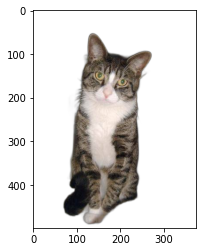

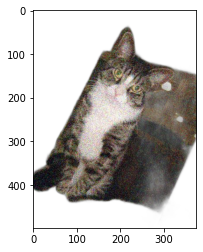

In [6]:
# display two images making sure they are the same
label = "cat.34"  # change this to see different images example: cat.34
image = mpimg.imread(f"{train_dir_nobg}/clean_{label}.png")
plt.imshow(image)
plt.show()

image = mpimg.imread(f"{train_dir_nobg}/noisy_clean_{label}.png")
plt.imshow(image)
plt.show()


Store data in data loaders

In [7]:
# Custom class to read in data
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

    def get_file_name(self):
        return self.main_dir


In [8]:
# get data into right format
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# read in data
dataset = CustomDataSet(train_dir_nobg, transform=data_transform)
print(dataset.__len__())
print(dataset[0].shape)


49988
torch.Size([3, 256, 256])


In [9]:
def random_split_dh(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac) 
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    indices = randperm(sum(lengths), generator=generator).tolist()
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]


Batch size: 32
select amount of data needed to train below

In [10]:
# Set up training and testing sets
data_size = dataset.__len__()

# Random split dataset
train_dataset, validation_dataset = random_split_dh(dataset, [round(0.02 * data_size), round(0.03 * data_size)])  # amount of data for training and testing

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=True)

print(f"length of traning dataloader {len(train_loader)}")
print(f"length of testing dataloader {len(test_loader)}")


length of traning dataloader 31
length of testing dataloader 1500


### Autoencoder:
We train our autoencoder on a high-performance computing cluster and save the model once it is trained. To see the main training loop please view the other python files in the directory. The code below is used to read in the saved model.

In [11]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        # encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        # decoder        
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x_lat = self.pool(x)

        # decoder
        x = F.relu(self.t_conv1(x_lat))
        x = torch.sigmoid(self.t_conv2(x))
              
        return x, x_lat

    # only runs decoder to return original image
    def run_decoder(self, latent):
        x = F.relu(self.t_conv1(latent))
        x = torch.sigmoid(self.t_conv2(x))
        return x


In [12]:
# initialize AutoEncoder
model = ConvAutoencoder()
model


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

## 3. Testing:
To test our method, we first randomly select 2 images of the same pet from our testing dataset. We first upload the noisy image to represent the image taken by the person that found the pet, and then we upload the clean image to represent the image from the owner. We then observe if the two image’s latent vectors can be matched based on similarity. So far, we not observed any mistakes but as the database size continues to grow we may have to make our model more complex. 


The provided image is then fed through the trained encoder which will convert the image to a lower-level latent vector that summarizes the image’s important features. This latent vector along with the contact information will be stored in our database.

1
torch.Size([3, 256, 256])
loss for img: 0.0016053421422839165
This image is already in our database
Input Image:


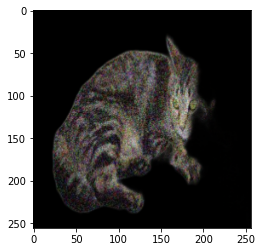

In [16]:
##################### USER INPUT #####################
contact = "jo: 508-837-0245"  # contact info
img_loc = "/content/drive/MyDrive/CS_539_final_proj/upload"  # path to image that should be uploaded: please only upload one image at a time
k = 3  # number of images to return
##################### USER INPUT #####################


warnings.filterwarnings('ignore')
for file_name in os.listdir(img_loc):
    img_name = file_name

image_shape = 3
model_path = "/content/drive/MyDrive/CS_539_final_proj/model.pt"
mse = nn.MSELoss()

# load trained model
model = ConvAutoencoder()
model.load_state_dict(torch.load(model_path))
model.eval()

# store image in dataloader
dataset = CustomDataSet(img_loc, transform=data_transform)
print(dataset.__len__())
print(dataset[0].shape)
test_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=True)


# feed image into encoder
for idx, img in enumerate(test_loader):
    df_results = pd.DataFrame()
    outputs, lat = model(img)
    loss = mse(outputs, img)
    #print(f"shape of lat: {lat.shape}")
    print(f"loss for img: {loss}")
    
    # save latent representation to database
    np.save(f"/content/drive/MyDrive/CS_539_final_proj/latent_database/{img_name}.npy", lat.detach().numpy())

    # save user meta data in csv: pk is imgae name, if image already exists do nothing
    meta_data = pd.read_csv("/content/drive/MyDrive/CS_539_final_proj/meta_data.csv", header = None).reset_index(drop=True)
    if img_name in list(meta_data[0]):
        print("This image is already in our database")
    else:
        with open('/content/drive/MyDrive/CS_539_final_proj/meta_data.csv', 'a') as csv_object:
            write = writer(csv_object)
            write.writerow([img_name, contact])
            csv_object.close()

# print input image
print("Input Image:")
plt.imshow(torch.squeeze(img).permute(1, 2, 0))


We then query the database and return the latent vector of the k-most similar latent vector using cosine similarity. These latent vectors are then fed through the trained decoder to recover the original images and the user can identify their lost pet and the corresponding contact information. 

Top k most similar images to the image you uploaded:
                                most_sim_name  most_sim_score               contact
7  Copy of Copy of noisy_clean_cat.16.png.npy        1.000000      jo: 508-837-0245
6                        clean_cat.16.png.npy        0.968706      jo: 508-837-0245
0          Copy of noisy_clean_cat.34.png.npy        0.962844  dennis: 508-837-9245
 
The most similar image is Copy of noisy_clean_cat.34.png.npy with a cosine score of 0.9628435373306274. Contact dennis: 508-837-9245 for more information
 
Copy of Copy of noisy_clean_cat.16.png.npy


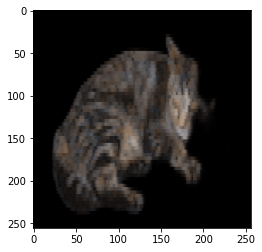

clean_cat.16.png.npy


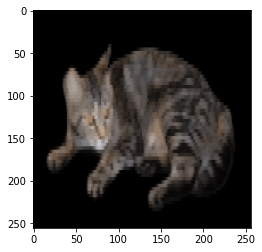

Copy of noisy_clean_cat.34.png.npy


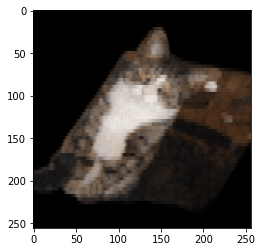

In [44]:
warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)

# lat we want to find similar images to from above
lost_pet = lat.detach().numpy()
lost_pet = lost_pet.flatten()


# read in meta data which contains contact information for the person the uploaded an image
meta_data = pd.read_csv("/content/drive/MyDrive/CS_539_final_proj/meta_data.csv", header = None).reset_index(drop=True)

# dataframe to organize most sim vectors
cols = ["most_sim_name", "most_sim_score", "most_sim_lat", "contact"]
latent_df = pd.DataFrame(columns=cols)

i = 0
# loop through latent database 
for file_name in os.listdir("/content/drive/MyDrive/CS_539_final_proj/latent_database"):
    saved_lat = np.load(f"/content/drive/MyDrive/CS_539_final_proj/latent_database/{file_name}")
    saved_lat_flat = saved_lat.flatten()

    # calcualte simularity score between lost_pet and each vector. closer to 1 -> more similar the vectors are
    cosine = np.dot(lost_pet, saved_lat_flat) / (norm(lost_pet) * norm(saved_lat_flat))

    # get contact info for person that uploaded the most sim image
    contact = str(meta_data.loc[meta_data[0] == file_name[:-4], 1].item())
    
    if file_name[:-4] != img_name:
        # save file name, sim score, and vector in dataframe
        latent_df.loc[len(latent_df.index)] = [file_name, cosine, saved_lat, contact] 
        i = i + 1  # track name of current vector 

# top k dataframe ordered by sim score
top_k = latent_df.nlargest(k, columns="most_sim_score", keep = "all")

print("Top k most similar images to the image you uploaded:")
print(top_k[['most_sim_name', 'most_sim_score', 'contact']].head(k))

most_sim_name = top_k["most_sim_name"][0]
most_sim_score = top_k["most_sim_score"][0]
contact = top_k["contact"][0]

print(" ")
print(f"The most similar image is {most_sim_name} with a cosine score of {most_sim_score}. Contact {contact} for more information")
print(" ")
top_k.reset_index(drop=True, inplace=True)

# feed latent vector back through decoder to get the original uploaded image back
i = 0
for ord_lat in top_k["most_sim_lat"]:
    most_sim_lat_tensor = torch.tensor(ord_lat).cuda()

    model = model.cuda()

    x_hat = model.run_decoder(torch.tensor(most_sim_lat_tensor)).cpu()
    
    print(top_k["most_sim_name"][i])

    with torch.no_grad():
        plt.imshow(torch.squeeze(x_hat).permute(1, 2, 0))
        plt.show()
    i = i+1
